In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

### Aggregated Mean Wind Speed Time Series
Every sample is the average wind speed across all turbines

In [2]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
average_mean_wind_speeds = scada_data[['dtTimeStamp','WindSpeedMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindSpeedMean']]

print("Number of turbines: " + str(len(scada_data['intObjectId'].unique())))
print(average_mean_wind_speeds.head(5))

Number of turbines: 27
                     WindSpeedMean
dtTimeStamp                       
2019-08-01 00:00:00       2.677778
2019-08-01 00:10:00       2.914815
2019-08-01 00:20:00       3.700000
2019-08-01 00:30:00       4.488889
2019-08-01 00:40:00       4.977778


### Raw Data Plot

Text(0.5, 1.0, 'Seasonal Component')

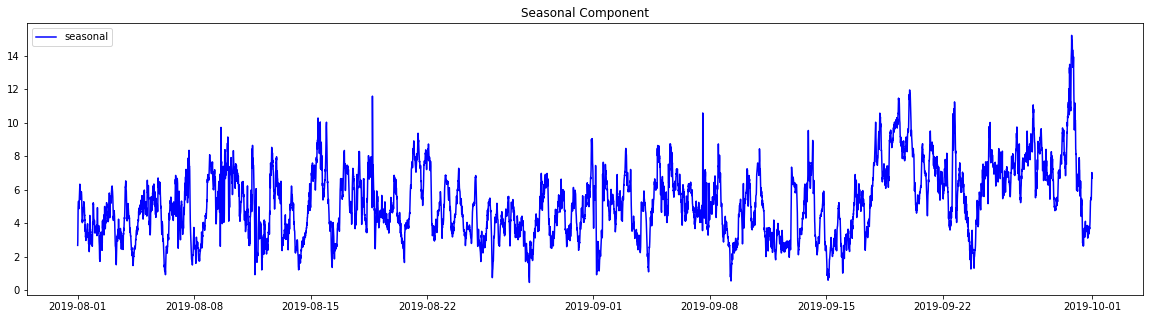

In [3]:
plt.figure(figsize=(20,5))
plt.plot(average_mean_wind_speeds["WindSpeedMean"], color='blue', label='seasonal')
plt.legend(loc='best')
plt.title('Seasonal Component')

### Forecasting 1 time step
Forecasting the 10 minutes and then retraining with the real value for the forecast and repeating

In [4]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt

X = average_mean_wind_speeds[0:2000]
size = int(len(X) * 0.04)
train, test = X[0:size], X[size:len(X)]
history = train
predictions = pd.DataFrame(index=test.index, columns=['prediction'])
times = []
for i, row in test.iterrows():
    start = dt.datetime.now()
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0].flatten()[0]
    predictions.loc[i]['prediction'] = yhat
    history.loc[i] = row['WindSpeedMean']
    end = dt.datetime.now()
    times.append(end-start)
    #print('predicted=%f, expected=%f' % (predictions.loc[i]['prediction'], row['WindSpeedMean']))

print('done')
print((sum(times, dt.timedelta()) / len(times)))

done
0:00:00.055882


Text(0.5, 1.0, 'Real vs Predictions')

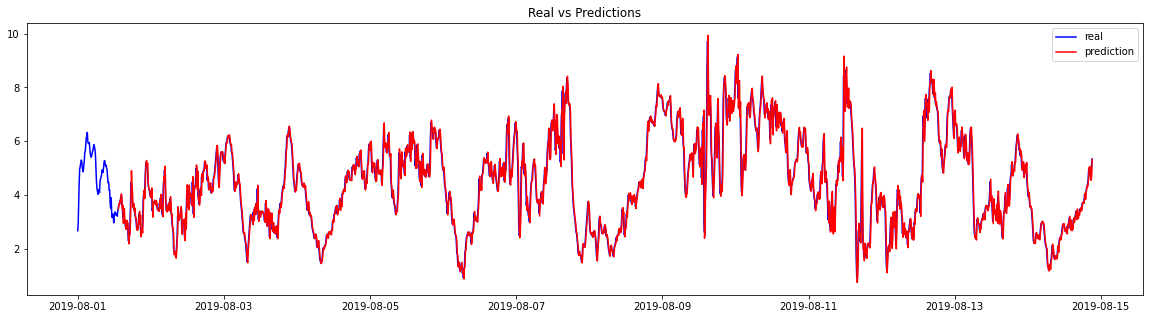

In [5]:
plt.figure(figsize=(20,5))
plt.plot(history, color='blue', label='real')
plt.plot(predictions, color='red', label='prediction')
plt.legend(loc='best')
plt.title('Real vs Predictions')

In [6]:
combined_df = pd.concat([history,predictions], axis=1).dropna()
print(combined_df)

                     WindSpeedMean prediction
dtTimeStamp                                  
2019-08-01 13:20:00       3.511111    3.48587
2019-08-01 13:30:00       3.644444    3.56695
2019-08-01 13:40:00       3.655556    3.71109
2019-08-01 13:50:00       3.759259    3.66829
2019-08-01 14:00:00       3.770370    3.81328
...                            ...        ...
2019-08-14 20:30:00       4.744444    5.06187
2019-08-14 20:40:00       4.588889    4.67499
2019-08-14 20:50:00       4.725926    4.55319
2019-08-14 21:00:00       5.211111    4.75884
2019-08-14 21:10:00       5.344444    5.32589

[1920 rows x 2 columns]


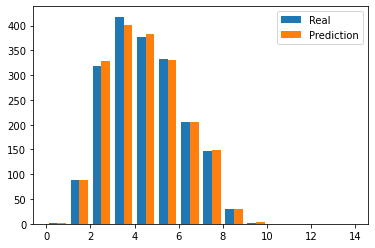

In [7]:
import random
import numpy
from matplotlib import pyplot

plt.hist([combined_df['WindSpeedMean'], combined_df['prediction']], bins=list(range(0,15)), label=['Real', 'Prediction'])
plt.legend(loc='upper right')
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(combined_df['WindSpeedMean'], combined_df['prediction'])
print('Test MSE: %.3f' % error)

Test MSE: 0.127


### Forecasting 1 hour

In [9]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt


n_step = 6
X = average_mean_wind_speeds[0:2000]
size = int(len(X) * 0.04)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train.values]
predictions = list()
times = []
test_indices = [i for i in range(0, len(test.values)) if i%n_step==0]
for i in test_indices:
    start = dt.datetime.now()
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(n_step)
    yhat = output[0].flatten()
    predictions.extend(yhat)
    history.extend(test.values[i:i+n_step])
    end = dt.datetime.now()
    times.append(end-start)
    #print('predicted=%f, expected=%f' % (predictions.loc[i]['prediction'], row['WindSpeedMean']))

print('done')
print((sum(times, dt.timedelta()) / len(times)))


done
0:00:00.053096


1920


Text(0.5, 1.0, 'Real vs Predictions')

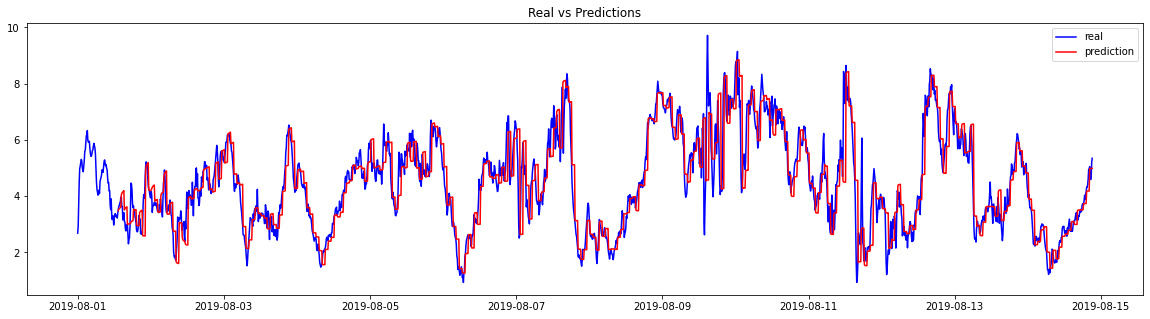

In [10]:
print(len(predictions))

predictions_df = pd.DataFrame(index=test.index, columns=['Predictions'])
predictions_df['Predictions'] = predictions

# print('done')

plt.figure(figsize=(20,5))
plt.plot(X, color='blue', label='real')
plt.plot(predictions_df, color='red', label='prediction')
plt.legend(loc='best')
plt.title('Real vs Predictions')

                     WindSpeedMean  Predictions
dtTimeStamp                                    
2019-08-01 13:20:00       3.511111     3.485874
2019-08-01 13:30:00       3.644444     3.530374
2019-08-01 13:40:00       3.655556     3.556968
2019-08-01 13:50:00       3.759259     3.575814
2019-08-01 14:00:00       3.770370     3.591306
...                            ...          ...
2019-08-14 20:30:00       4.744444     4.982537
2019-08-14 20:40:00       4.588889     4.983999
2019-08-14 20:50:00       4.725926     4.985254
2019-08-14 21:00:00       5.211111     4.986460
2019-08-14 21:10:00       5.344444     4.987655

[1920 rows x 2 columns]


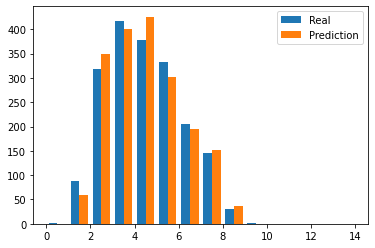

In [11]:
import random
import numpy
from matplotlib import pyplot

combined_df = pd.concat([X,predictions_df], axis=1).dropna()
print(combined_df)

plt.hist([combined_df['WindSpeedMean'], combined_df['Predictions']], bins=list(range(0,15)), label=['Real', 'Prediction'])
plt.legend(loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(combined_df['WindSpeedMean'], combined_df['Predictions'])
print('Test MSE: %.3f' % error)

Test MSE: 0.583
